# Competition 2 - Marketing Campaign

## Challenge Overview

You are running the marketing campaign for a brand new pocket device. Initially you can sign contracts with a few people to advertize your gadget among their neigbours. The more "famous" person you are picking the greater price appears in the contract.<br> 
Contract cost can be calculated as 300$\$$ * NN(i), where NN(i) is the number of neigbours of the person i. <br>
If at least 18\% a person's neighbors have already been affected, then he/she will also be affected tomorrow.<br> 
You earn 50$\$$ per each affected person. <br>
Every day you have to choose whether to sign new contracts or wait. <br>
You need time to discuss terms of a contract, so you cannot sign more than 10 contracts on the same day.<br> 
Your task is to maximize profit of your campaign with an initial budget of 10,000$\$$. <br>
Your campaign is considered completed after 60 days.

Again, all parameters of the task:
1. Budget: 10,000\$
2. Contract cost: 300$ * NN(i)
3. Income per person: 50\$
4. Exposure threshold: 18\%
5. Contracts limit: 10 per day
6. Time limit: 60 days

A model of society is based on undirected SNAP Facebook network edge_list.txt

### Evaluation Criteria
On the leaderboard you will see three scores:
1. Profit — calculated as "total amount of money at the end - initial budget". This is the main score.
2. Accepted — the total number of accepted people at the end.
3. Days — the total duration of your campaign.
#### Baselines
Baselines are calculated as follows:
* Simultaneously sign 10 random contracts on the first day. Decrease the number of contracts if you do not have enough money. Wait the end of the campaign and calculate your profit. Repeat 10000 times
* Baseline for grade 4: beat an average positive profit
* Baseline for grade 6: beat an average + standard deviation positive profit

### Submission Guidelines
Submit a txt with days and contracts which will be signed. That looks like a python dict object, the key is a day, the value is a list of counterparties. Numbering of days from 0. 

**Example 1**
{
    # On the first day, I will sign contracts with 47 and 138
    0: [47, 138],
    # On the third day, I will sign 2 more contracts
    2: [3789, 262]
}
Result of this campaign: 
Profit: -2350
Days: 10
Affected: 29

**Example 2**
{
    # I do not want to do anything
}
Result of this campaign: 
Profit: 0
Days: 1
Affected: 0

**Exceptions**
You may encounter two types of exceptions after submission:
* You cannot sign more than 10 contracts at the same day.
* Not enough money for the contract with 2919. The contract cost is 300$\$$, you have only 100$\$$.

In this case, the evaluation will be interrupted and your scores will not be calculated. You can find log files with detailed information on the My Submissions page, stdout file. 

**To sign a contract with an already affected person is not a problem, you will just waste your money.**

In [1]:
import json
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter

In [2]:
edgelist = []
with open('edge_list.txt') as f:
    data = f.read().splitlines()
    for s in data:
        edge_from, edge_to = map(int, s.split())
        edgelist.append((edge_from, edge_to))
G = nx.Graph(edgelist)
print(f'nodes: {G.number_of_nodes()}')
print(f'edges: {G.number_of_edges()}')

nodes: 3953
edges: 84070


In [3]:
def get_graph_stats(graph):
    d = {}
    number_nodes = graph.number_of_nodes()  # number of nodes
    d['number_nodes'] = number_nodes
    
    number_edges = graph.number_of_edges()  # number of nodes
    d['number_edges'] = number_edges

    number_cc = nx.number_connected_components(graph)  # number of connected components
    d['number_cc'] = number_cc
    
    average_clustering = nx.average_clustering(graph)  # average clustering coefficient
    d['average_clustering'] = average_clustering

    return d

In [4]:
# steps - dict(day: list of affected nodes)
def process_campaign(graph, steps, logs=0, budget=10000):
    budget = budget
    nodes = list(graph.nodes())
    A = np.zeros(4038 + 1) # список "зараженных" (узлы не по порядку)
    
    # заражаем стартовые узлы
    start_list = steps[0]
    if len(start_list) > 10:
        return f'Only 10 contracts per day'
    for node in start_list:
        #G.nodes[node]['affected'] = 1
        neighbors_cnt = len(list(G.neighbors(node)))
        budget -= neighbors_cnt * 300
        if budget < 0:
            return f'Budget is over :('
        A[node] = 1
        
    for i in range(1, 60):
        # заражаем соседей по результатам предыдущего дня
        affected_nodes = []
        new_affected_nodes = []
        for node in nodes: 
            if A[node] == 1:
                affected_nodes.append(node)
        for node in affected_nodes:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if A[neighbor] == 0:
                    neighbors_of_neighbor = list(G.neighbors(neighbor))
                    affected_percent = sum([A[j] for j in neighbors_of_neighbor]) / len(neighbors_of_neighbor) * 100
                    if affected_percent >= 18:
                        new_affected_nodes.append(neighbor)
        for node in list(set(new_affected_nodes)):
            A[node] = 1
            budget += 50
        
        # заражаем узлы текущего дня
        node_list = steps[i]
        if len(node_list) > 10:
            return f'Only 10 contracts per day'
        
        for node in node_list: 
            if A[node] == 0:
                neighbors_cnt = len(list(G.neighbors(node)))
                budget -= neighbors_cnt * 300
                if budget < 0:
                    return f'Budget is over :('
                A[node] = 1
        if logs == 2:
            print(f'{i} Количество зараженных: {sum(A)}, бюджет: {budget}')
    if logs == 1:
        print(f'Итоговое количество зараженных: {sum(A)}, итоговый бюджет: {budget}')
    return A, sum(A), budget

In [5]:
get_graph_stats(G)

{'number_nodes': 3953,
 'number_edges': 84070,
 'number_cc': 15,
 'average_clustering': 0.5437653008207222}

In [6]:
# словарь со степенями вершин
gc_degrees = dict(G.degree)
# датафрейм со с епенями вершин
gc = pd.DataFrame()
gc['node'] = gc_degrees.keys()
gc['degree'] = gc_degrees.values()
gc['cost'] = gc['degree'] * 300
gc = gc.sort_values(by='cost', ascending=False)
gc.head(10)

,node,degree,cost
320,2543,293,87900
1758,2347,290,87000
490,1888,253,75900
574,1800,244,73200
521,1663,234,70200
602,1352,233,69900
1750,2266,233,69900
900,483,228,68400
561,1730,225,67500
3032,1985,223,66900


In [54]:
%%time
res_test = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
for node in list(G.nodes):
    gc_steps[0] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_test = res_test.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_test.sort_values(by=['profit','affected'], ascending=False).head(10)

CPU times: user 12min 12s, sys: 2.24 s, total: 12min 15s
Wall time: 12min 24s


,A,affected,degree,node,profit
1067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",863.0,37.0,1304.0,1032000.0
1782,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",701.0,16.0,3057.0,1030200.0
1237,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",701.0,57.0,1505.0,1017900.0
3377,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,6.0,2263.0,1009000.0
3380,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,6.0,2528.0,1009000.0
3378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,7.0,2548.0,1008700.0
3375,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,9.0,2113.0,1008100.0
3376,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,9.0,2439.0,1008100.0
3373,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,11.0,2450.0,1007500.0
3384,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,12.0,2217.0,1007200.0


In [55]:
res_test['final_pr'] = res_test['profit'] - 1000000
res_test.sort_values(by=['final_pr','affected'], ascending=False).head(30)

,A,affected,degree,node,profit,final_pr
1067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",863.0,37.0,1304.0,1032000.0,32000.0
1782,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",701.0,16.0,3057.0,1030200.0,30200.0
1237,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",701.0,57.0,1505.0,1017900.0,17900.0
3377,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,6.0,2263.0,1009000.0,9000.0
3380,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,6.0,2528.0,1009000.0,9000.0
3378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,7.0,2548.0,1008700.0,8700.0
3375,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,9.0,2113.0,1008100.0,8100.0
3376,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,9.0,2439.0,1008100.0,8100.0
3373,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,11.0,2450.0,1007500.0,7500.0
3384,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,12.0,2217.0,1007200.0,7200.0


In [61]:
%%time
res_1 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]

result = process_campaign(G, gc_steps, logs=2)
res_1 = res_1.append({'node': gc_steps[0], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_1.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 258.0, бюджет: 12750
12 Количество зараженных: 317.0, бюджет: 15700
13 Количество зараженных: 364.0, бюджет: 18050
14 Количество зараженных: 417.0, бюджет: 20700
15 Количество зараженных: 469.0, бюджет: 23300
16 Количество зараженных: 526.0, бюджет: 26150
17 Количество зараженных: 591.0, бюджет: 29400
18 Количество зараженных: 637.0, бюджет: 31700
19 Количество зараженных: 658.0, бюджет: 32750
20 Количество зараженных: 677.0, бюджет: 33700
21 Количество зараженных: 696.0, бюджет: 34650
22 Количество зараженных: 713.0, бюдже

,A,affected,node,profit
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1072.0,"[3057, 2263, 167, 3991, 3939]",53450.0


In [57]:
37 * 300

11100

In [7]:
%%time
res_2 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]

result = process_campaign(G, gc_steps, logs=2)
res_2 = res_2.append({'node': gc_steps[14], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_2.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 319.0, бюджет: 4650
13 Количество зараженных: 367.0, бюджет: 7050
14 Количество зараженных: 423.0, бюджет: 9850
15 Количество зараженных: 478.0, бюджет: 12600
16 Количество зараженных: 537.0, бюджет: 15550
17 Количество зараженных: 604.0, бюджет: 18900
18 Количество зараженных: 651.0, бюджет: 21250
19 Количество зараженных: 674.0, бюджет: 22400
20 Количество зараженных: 696.0, бюджет: 23500
21 Количество зараженных: 719.0, бюджет: 24650
22 Количество зараженных: 744.0, бюджет: 2

,A,affected,node,profit
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1835.0,[],80450.0


In [8]:
A_start = list(res_2.iloc[0]['A'])

In [68]:
next_nodes = []
for node in list(G.nodes):
    if A_start[node] == 0:
        next_nodes.append(node)
print(len(next_nodes))

2118


In [75]:
neighbors = []
#limit = int(400 / 300)
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:# and gc_degrees[neighbor] <= limit:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 12 дня: {len(neighbors)}')

Узлы для 12 дня: 706


In [76]:
sorted(neighbors)[:10]

[40, 51, 80, 83, 89, 96, 99, 109, 119, 128]

In [ ]:
%%time
res_3 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[12] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_3 = res_3.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_3.sort_values(by=['profit', 'affected'], ascending=False).head(10)

1600
1700
1800


In [ ]:
# 3847 12 9000 453
# 857 10 7500 411
# 3916 6 4050 318
# 3979 11 3450 336

In [9]:
12 * 300

3600

In [10]:
%%time
res_4 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]

result = process_campaign(G, gc_steps, logs=2)
res_4 = res_4.append({'node': gc_steps[12], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_4.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 431.0, бюджет: 6600
15 Количество зараженных: 491.0, бюджет: 9600
16 Количество зараженных: 555.0, бюджет: 12800
17 Количество зараженных: 629.0, бюджет: 16500
18 Количество зараженных: 680.0, бюджет: 19050
19 Количество зараженных: 708.0, бюджет: 20450
20 Количество зараженных: 741.0, бюджет: 22100
21 Количество зараженных: 769.0, бюджет: 23500
22 Количество зараженных: 802.0, бюджет: 25

,A,affected,node,profit
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2288.0,[3847],99450.0


In [15]:
A_start = list(res_4.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 13 дня: {len(neighbors)}')

Узлы для 13 дня: 696


In [16]:
%%time
res_5 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[13] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_5 = res_5.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_5.sort_values(by=['profit', 'affected'], ascending=False).head(10)

1600
1700
1800
2300
2400
2800
3000
3700
CPU times: user 1h 21min 41s, sys: 49.9 s, total: 1h 22min 31s
Wall time: 1h 26min 14s


,A,affected,degree,node,profit
519,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,13.0,2522.0,1100450.0
370,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,20.0,2096.0,1098350.0
411,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,21.0,2208.0,1098050.0
522,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,22.0,2531.0,1097750.0
361,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,25.0,2065.0,1096850.0
477,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,27.0,2389.0,1096250.0
488,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,27.0,2432.0,1096250.0
396,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,30.0,2163.0,1095350.0
156,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2642.0,43.0,1398.0,1094200.0
168,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2642.0,45.0,1460.0,1093600.0


In [17]:
13 * 300

3900

In [18]:
%%time
res_6 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]

result = process_campaign(G, gc_steps, logs=2)
res_6 = res_6.append({'node': gc_steps[14], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_6.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 492.0, бюджет: 5700
16 Количество зараженных: 556.0, бюджет: 8900
17 Количество зараженных: 630.0, бюджет: 12600
18 Количество зараженных: 681.0, бюджет: 15150
19 Количество зараженных: 709.0, бюджет: 16550
20 Количество зараженных: 742.0, бюджет: 18200
21 Количество зараженных: 771.0, бюджет: 19650
22 Количество зараженных: 805.0, бюджет: 213

,A,affected,node,profit
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2587.0,[2522],110450.0


In [19]:
A_start = list(res_6.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 15 дня: {len(neighbors)}')

Узлы для 15 дня: 677


In [20]:
%%time
res_7 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[15] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_7 = res_7.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_7.sort_values(by=['profit', 'affected'], ascending=False).head(10)

1600
1700
1800
2200
2300
2500
2600
2800
3000
3700
CPU times: user 1h 9min 53s, sys: 7.79 s, total: 1h 10min 1s
Wall time: 1h 10min 21s


,A,affected,degree,node,profit
92,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2941.0,14.0,1084.0,1113900.0
18,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,9.0,146.0,1108550.0
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,19.0,7.0,1105550.0
19,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,19.0,148.0,1105550.0
175,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2941.0,43.0,1398.0,1105200.0
187,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2941.0,45.0,1460.0,1104600.0
38,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,25.0,324.0,1103750.0
41,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,26.0,339.0,1103450.0
17,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,27.0,128.0,1103150.0
39,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",2804.0,29.0,329.0,1102550.0


In [21]:
A_start = np.zeros(4038 + 1)
node = 1084
degree = gc_degrees[node]
print(degree)
print(degree * 14 / 100)
node_neighbors = list(G.neighbors(node))
print(node_neighbors)
labels = []
degrees = []
for neighbor in node_neighbors:
    labels.append(A_start[neighbor])
    degrees.append(gc_degrees[neighbor])
print(labels)
print(degrees)

14
1.96
[1605, 1173, 1768, 1074, 897, 1570, 1620, 1571, 1029, 1722, 1519, 1470, 995, 1458]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[89, 114, 208, 62, 65, 123, 127, 59, 78, 55, 32, 70, 65, 32]


In [22]:
14 * 300

4200

In [23]:
%%time
res_8 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]

result = process_campaign(G, gc_steps, logs=2)
res_8 = res_8.append({'node': gc_steps[15], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_8.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 493.0, бюджет: 1500
16 Количество зараженных: 557.0, бюджет: 4700
17 Количество зараженных: 631.0, бюджет: 8400
18 Количество зараженных: 683.0, бюджет: 11000
19 Количество зараженных: 710.0, бюджет: 12350
20 Количество зараженных: 743.0, бюджет: 14000
21 Количество зараженных: 772.0, бюджет: 15450
22 Количество зараженных: 806.0, бюджет: 1715

,A,affected,node,profit
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2941.0,[1084],123900.0


In [25]:
A_start = list(res_8.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 16 дня: {len(neighbors)}')

Узлы для 16 дня: 400


In [26]:
%%time
res_9 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[16] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_9 = res_9.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_9.sort_values(by=['profit', 'affected'], ascending=False).head(10)

2200
2300
2500
2600
2800
3000
3700
CPU times: user 40min 50s, sys: 4.22 s, total: 40min 54s
Wall time: 41min 4s


,A,affected,degree,node,profit
18,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,9.0,146.0,1122000.0
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,19.0,7.0,1119000.0
19,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,19.0,148.0,1119000.0
38,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,25.0,324.0,1117200.0
41,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,26.0,339.0,1116900.0
17,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,27.0,128.0,1116600.0
39,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,29.0,329.0,1116000.0
14,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,36.0,109.0,1113900.0
24,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,38.0,213.0,1113300.0
37,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,38.0,323.0,1113300.0


In [35]:
%%time
res_10 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146]

result = process_campaign(G, gc_steps, logs=2)
res_10 = res_10.append({'node': gc_steps[16], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_10.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 493.0, бюджет: 1500
16 Количество зараженных: 558.0, бюджет: 2000
17 Количество зараженных: 632.0, бюджет: 5700
18 Количество зараженных: 684.0, бюджет: 8300
19 Количество зараженных: 711.0, бюджет: 9650
20 Количество зараженных: 744.0, бюджет: 11300
21 Количество зараженных: 773.0, бюджет: 12750
22 Количество зараженных: 807.0, бюджет: 14450


,A,affected,node,profit
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3158.0,[146],132000.0


In [28]:
A_start = list(res_10.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 17 дня: {len(neighbors)}')

Узлы для 17 дня: 363


In [29]:
%%time
res_11 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[17] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_11 = res_11.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_11.sort_values(by=['profit', 'affected'], ascending=False).head(10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
2200
2300
2500
2600
2800
3000
3700


,A,affected,degree,node,profit
309,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3172.0,6.0,3216.0,1120850.0
7,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3166.0,6.0,871.0,1120550.0
343,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3164.0,6.0,3669.0,1120450.0
345,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3164.0,6.0,3700.0,1120450.0
349,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3164.0,6.0,3813.0,1120450.0
352,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3164.0,6.0,3864.0,1120450.0
359,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3164.0,6.0,3911.0,1120450.0
1,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3166.0,7.0,89.0,1120250.0
4,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3166.0,7.0,319.0,1120250.0
326,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3159.0,6.0,3445.0,1120200.0


In [31]:
%%time
res_12 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146, 3216]
#gc_steps[17] = [3216]

result = process_campaign(G, gc_steps, logs=2)
res_12 = res_12.append({'node': gc_steps[16], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_12.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 493.0, бюджет: 1500
16 Количество зараженных: 559.0, бюджет: 200
17 Количество зараженных: 634.0, бюджет: 3950
18 Количество зараженных: 689.0, бюджет: 6700
19 Количество зараженных: 723.0, бюджет: 8400
20 Количество зараженных: 759.0, бюджет: 10200
21 Количество зараженных: 787.0, бюджет: 11600
22 Количество зараженных: 821.0, бюджет: 13300
2

,A,affected,node,profit
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3172.0,"[146, 3216]",130850.0


In [32]:
A_start = list(res_12.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)


neighbors = list(set(neighbors))
print(f'Узлы для 17 дня: {len(neighbors)}')

Узлы для 17 дня: 362


In [33]:
%%time
res_13 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146, 3216]

for node in sorted(neighbors):
    if node % 100 == 0:
        print(node)
    gc_steps[17] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_13 = res_13.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_13.sort_values(by=['profit', 'affected'], ascending=False).head(10)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
2200
2300
2500
2600
2800
3000
3700


,A,affected,degree,node,profit
7,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3180.0,6.0,871.0,1119400.0
342,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,6.0,3669.0,1119300.0
344,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,6.0,3700.0,1119300.0
348,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,6.0,3813.0,1119300.0
351,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,6.0,3864.0,1119300.0
358,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,6.0,3911.0,1119300.0
1,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3180.0,7.0,89.0,1119100.0
4,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3180.0,7.0,319.0,1119100.0
325,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3173.0,6.0,3445.0,1119050.0
329,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3178.0,7.0,3502.0,1119000.0


In [41]:
%%time
res_14 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146, 3216]
gc_steps[17] = [871]

result = process_campaign(G, gc_steps, logs=2)
res_14 = res_14.append({'node': gc_steps[17], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_14.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 493.0, бюджет: 1500
16 Количество зараженных: 559.0, бюджет: 200
17 Количество зараженных: 635.0, бюджет: 2150
18 Количество зараженных: 694.0, бюджет: 5100
19 Количество зараженных: 735.0, бюджет: 7150
20 Количество зараженных: 768.0, бюджет: 8800
21 Количество зараженных: 795.0, бюджет: 10150
22 Количество зараженных: 829.0, бюджет: 11850
23

,A,affected,node,profit
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3180.0,[871],129400.0


In [43]:
A_start = list(res_14.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)

next_nodes = []
for node in list(G.nodes):
    if A_start[node] == 0.0:
        next_nodes.append(node)


neighbors = list(set(neighbors))
next_nodes = list(set(next_nodes))
print(f'Узлы для 18 дня: {len(next_nodes)}')

Узлы для 18 дня: 773


In [44]:
%%time
res_15 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146, 3216]
gc_steps[17] = [871]

for node in sorted(next_nodes):
    if node % 100 == 0:
        print(node)
    gc_steps[18] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_15 = res_15.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_15.sort_values(by=['profit', 'affected'], ascending=False).head(10)

600
700
800
2200
2300
2500
2600
2800
3000
3300
3400
3700
CPU times: user 1h 20min 10s, sys: 7.26 s, total: 1h 20min 18s
Wall time: 1h 20min 29s


,A,affected,degree,node,profit
499,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3397.0,32.0,2745.0,1120600.0
10,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3188.0,1.0,154.0,1119450.0
6,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3183.0,1.0,90.0,1119200.0
8,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3183.0,1.0,145.0,1119200.0
113,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3183.0,1.0,749.0,1119200.0
139,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3183.0,1.0,775.0,1119200.0
2,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3182.0,1.0,33.0,1119150.0
3,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3182.0,1.0,42.0,1119150.0
16,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3182.0,1.0,233.0,1119150.0
17,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3182.0,1.0,244.0,1119150.0


In [67]:
good_nodes_1 = list(set([3057, 2263, 167, 3991, 3939, 1304, 3847, 2522, 1084, 146, 871, 2745]))
good_nodes_1_neighbors = []
c = {}

for node in good_nodes_1:
    c[node] = 'red'
    node_neighbors = list(G.neighbors(node))
    for neigh in node_neighbors:
        if neigh not in c.keys():
            c[neigh] = 'LightGreen'
        else:
            c[neigh] = 'coral'
            print(f'{neigh} - CORAL')
    c[node] = 'red'
    node_neighbors.append(node)
    good_nodes_1_neighbors.extend(node_neighbors)

good_nodes_1_neighbors = list(set(good_nodes_1_neighbors))

print(len(good_nodes_1_neighbors))
print(good_nodes_1_neighbors)
print(c[3772])

168
[1536, 1029, 3078, 2567, 3592, 3080, 3610, 1052, 32, 1570, 1571, 2087, 3626, 2608, 50, 1074, 2101, 53, 1084, 2621, 1090, 3139, 1605, 3143, 3660, 3153, 1106, 1620, 3674, 3164, 3677, 93, 3679, 1634, 3174, 2151, 1127, 2664, 1131, 2669, 2161, 2676, 1141, 2678, 119, 1656, 2176, 136, 137, 146, 148, 1173, 3222, 1188, 3237, 167, 1703, 1709, 2734, 2227, 2745, 1722, 3772, 1725, 1726, 3775, 3263, 2760, 1225, 1228, 3278, 1236, 3284, 2263, 1759, 2786, 2789, 1768, 1258, 1260, 243, 1785, 3324, 3847, 2313, 1299, 1815, 1304, 2839, 1308, 285, 1310, 2347, 1840, 2864, 2866, 310, 2872, 313, 3387, 317, 3392, 2882, 3394, 3396, 1355, 3916, 337, 339, 1876, 1366, 857, 858, 2906, 2909, 3939, 870, 871, 3432, 3430, 879, 3953, 881, 2929, 3963, 895, 2431, 897, 3979, 2960, 2451, 2964, 3477, 3989, 3991, 2966, 924, 1955, 943, 2994, 1458, 3004, 3005, 1982, 4031, 1470, 1473, 3010, 965, 2510, 3022, 977, 985, 3546, 2522, 986, 1500, 990, 3033, 2528, 995, 1000, 1519, 3057, 1010, 3061, 2042, 2558]
LightGreen


In [68]:
print(list(G.neighbors(3057)))

[1656, 990, 1726, 3005, 3396, 3263, 3164, 2678, 2734, 2882, 2964, 3432, 3061, 3222, 3278, 2760]


In [69]:
print(list(G.neighbors(3847)))

[3953, 3775, 3674, 3677, 3610, 3592, 3626, 3979, 3772, 3660, 3916, 3477]


In [62]:
subG_1 = G.subgraph(good_nodes_1_neighbors)
colors = []
for node in list(subG_1.nodes):
    #if node in good_nodes_1:
    #    colors.append('red')
    #else:
    #    colors.append('LightGreen')
    colors.append(c[node])
print(len(colors))
#print(colors)

168


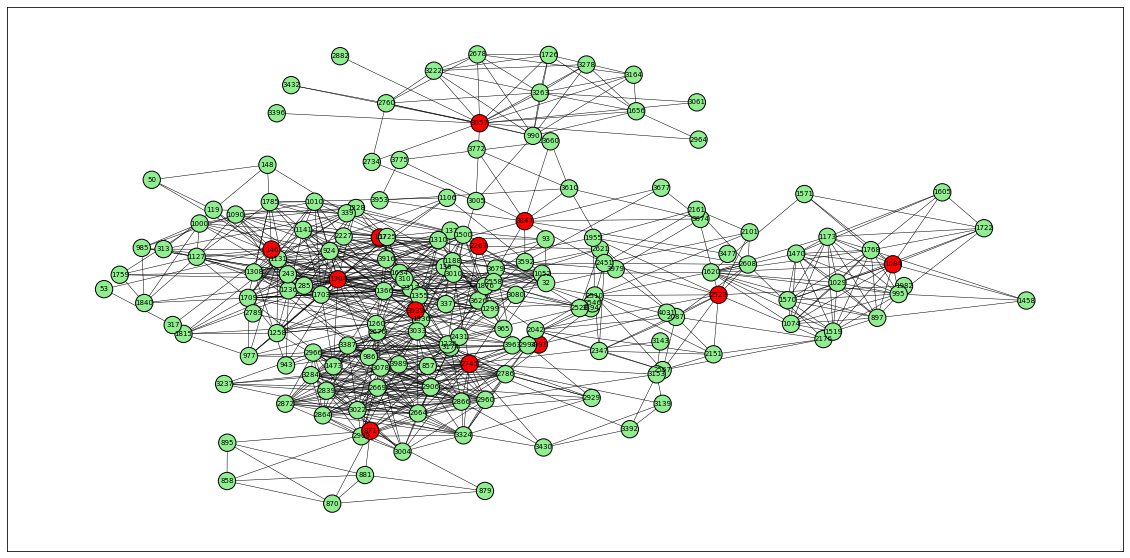

In [63]:
plt.figure(figsize=(20, 10))
#pos = nx.spring_layout(subG_1)
pos = nx.kamada_kawai_layout(subG_1)

nx.draw_networkx_nodes(subG_1, pos, node_size=300,
                               node_color=colors, 
                               vmin=0, vmax=3, 
                               cmap=plt.cm.rainbow,
                               edgecolors='black')
nx.draw_networkx_edges(subG_1, pos,
                       width=0.5,
                       node_size=300)
nx.draw_networkx_labels(subG_1, pos, font_size=7)
plt.show()

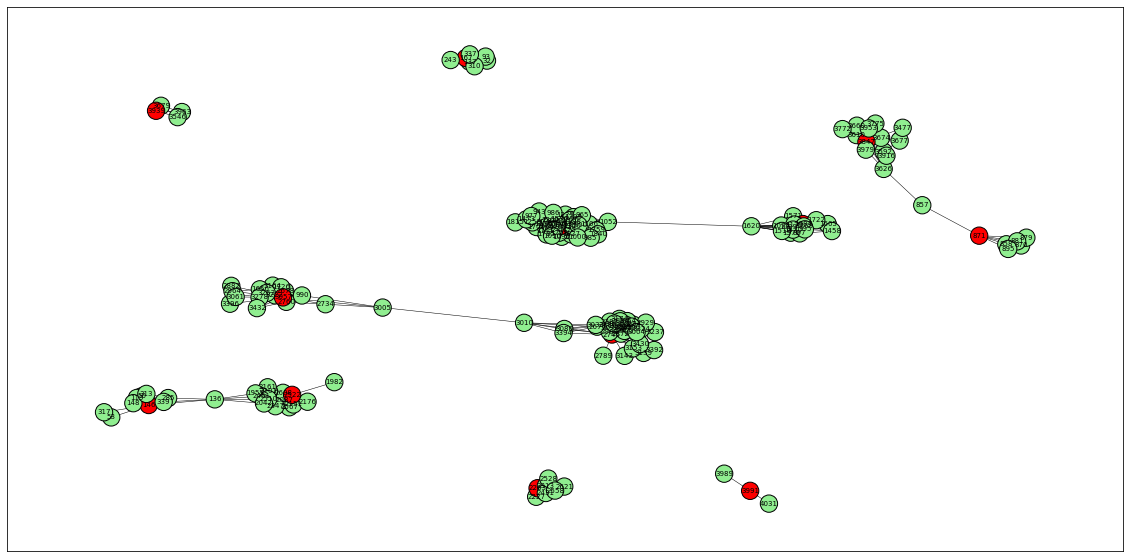

In [64]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(subG_1)
#pos = nx.kamada_kawai_layout(subG_1)

nx.draw_networkx_nodes(subG_1, pos, node_size=300,
                               node_color=colors, 
                               vmin=0, vmax=3, 
                               cmap=plt.cm.rainbow,
                               edgecolors='black')
nx.draw_networkx_edges(subG_1, pos,
                       width=0.5,
                       node_size=300)
nx.draw_networkx_labels(subG_1, pos, font_size=7)
plt.show()

In [48]:
nodes_degrees = pd.DataFrame()
for node in good_nodes_1:
    nodes_degrees = nodes_degrees.append({'node': node, 'degree': gc_degrees[node]}, ignore_index=True)
nodes_degrees

,degree,node
0,3.0,3939.0
1,6.0,167.0
2,12.0,3847.0
3,6.0,871.0
4,16.0,3057.0
5,13.0,2522.0
6,9.0,146.0
7,2.0,3991.0
8,37.0,1304.0
9,32.0,2745.0


In [83]:
%%time
res_16 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146]

gc_steps[19] = [2745]
gc_steps[20] = [154]

result = process_campaign(G, gc_steps, logs=2)
res_16 = res_16.append({'node': gc_steps[0], 'profit': result[2], 'affected': result[1],'A': result[0]}, ignore_index=True)

res_16.sort_values(by=['profit','affected'], ascending=False)


1 Количество зараженных: 11.0, бюджет: 400
2 Количество зараженных: 18.0, бюджет: 750
3 Количество зараженных: 29.0, бюджет: 1300
4 Количество зараженных: 52.0, бюджет: 2450
5 Количество зараженных: 80.0, бюджет: 3850
6 Количество зараженных: 109.0, бюджет: 5300
7 Количество зараженных: 150.0, бюджет: 7350
8 Количество зараженных: 177.0, бюджет: 8700
9 Количество зараженных: 194.0, бюджет: 9550
10 Количество зараженных: 219.0, бюджет: 10800
11 Количество зараженных: 259.0, бюджет: 1650
12 Количество зараженных: 320.0, бюджет: 1050
13 Количество зараженных: 371.0, бюджет: 3600
14 Количество зараженных: 432.0, бюджет: 2700
15 Количество зараженных: 493.0, бюджет: 1500
16 Количество зараженных: 558.0, бюджет: 2000
17 Количество зараженных: 632.0, бюджет: 5700
18 Количество зараженных: 684.0, бюджет: 8300
19 Количество зараженных: 712.0, бюджет: 50
20 Количество зараженных: 747.0, бюджет: 1450
21 Количество зараженных: 778.0, бюджет: 3000
22 Количество зараженных: 816.0, бюджет: 4900
23 Ко

,A,affected,node,profit
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3397.0,"[3057, 2263, 167, 3991, 3939]",133950.0


In [84]:
A_start = list(res_16.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)

next_nodes = []
for node in list(G.nodes):
    if A_start[node] == 0.0:
        next_nodes.append(node)


neighbors = list(set(neighbors))
next_nodes = list(set(next_nodes))
print(f'Узлы для 21 дня: {len(next_nodes)}')

Узлы для 21 дня: 556


In [85]:
%%time
res_17 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 167, 3991, 3939]
gc_steps[11] = [1304]
gc_steps[12] = [3847]
gc_steps[14] = [2522]
gc_steps[15] = [1084]
gc_steps[16] = [146]

gc_steps[19] = [2745]
gc_steps[20] = [154]

for node in sorted(next_nodes):
    if node % 100 == 0:
        print(node)
    gc_steps[21] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_17 = res_17.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_17.sort_values(by=['profit', 'affected'], ascending=False).head(10)


600
700
800
2200
2300
2500
2600
3700
CPU times: user 1h 49s, sys: 9.84 s, total: 1h 59s
Wall time: 1h 1min 23s


,A,affected,degree,node,profit
4,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,90.0,1123750.0
5,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,145.0,1123750.0
105,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,749.0,1123750.0
131,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,775.0,1123750.0
1,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,33.0,1123700.0
2,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,42.0,1123700.0
10,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,233.0,1123700.0
11,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,244.0,1123700.0
12,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,256.0,1123700.0
15,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,282.0,1123700.0


In [14]:
good_nodes_2 = list(set([3057, 2263, 167, 3991, 3939, 64, 3216, 2522, 146, 3961, 3916, 319, 871, 3481, 3657, 
                         4, 3045, 2584, 3325, 1808, 3095, 3057, 2263, 167, 3991, 3939, 443, 2788, 454, 3787, 
                         154, 263, 3775, 54, 894, 1027, 910, 2483, 3813, 2522, 3892, 2584, 3314, 3639, 4, 
                         1840, 943, 899, 1084, 2745, 3057, 2263, 167, 3991, 3939, 1304, 3847, 2522, 1084, 
                         146, 871, 2745, 90, 33]))
good_nodes_2_neighbors = []
neigh_2 = []
c = {}

for node in good_nodes_2:
    c[node] = 'red'
    node_neighbors = list(G.neighbors(node))
    for neigh in node_neighbors:
        if neigh not in c.keys():
            c[neigh] = 'LightGreen'
        else:
            c[neigh] = 'coral'
            neigh_2.append(neigh)
            #print(f'{neigh} - CORAL')
    c[node] = 'red'
    node_neighbors.append(node)
    good_nodes_2_neighbors.extend(node_neighbors)

good_nodes_2_neighbors = list(set(good_nodes_2_neighbors))
neigh_2 = list(set(neigh_2))
print(len(good_nodes_2_neighbors))
#print(good_nodes_2_neighbors)
print(len(neigh_2))

367
63


In [15]:
subG_2 = G.subgraph(good_nodes_2_neighbors)
colors = []
for node in list(subG_2.nodes):
    colors.append(c[node])
print(len(colors))

367


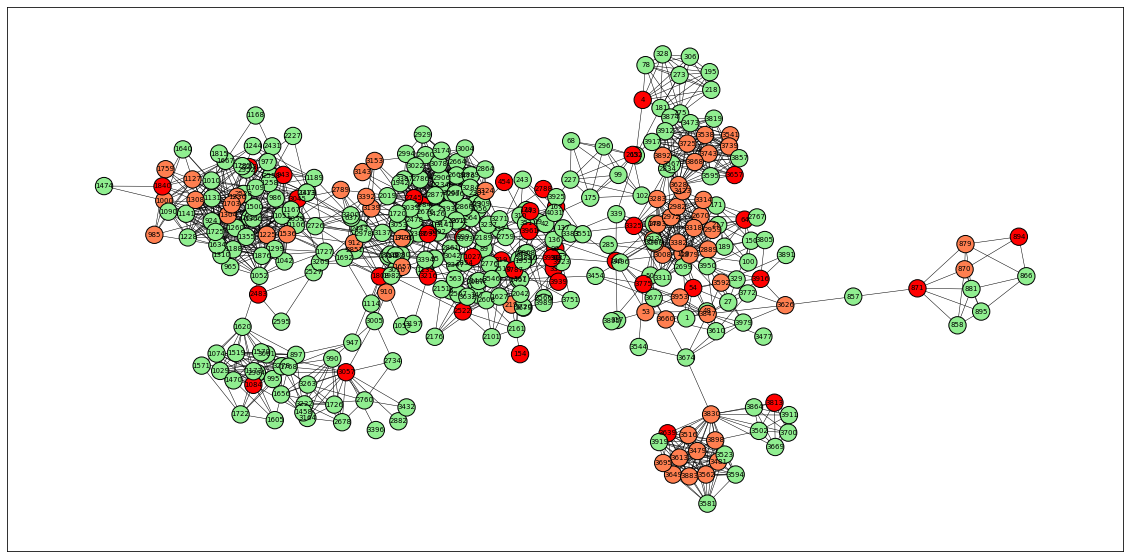

In [16]:
plt.figure(figsize=(20, 10))
pos = nx.kamada_kawai_layout(subG_2)

nx.draw_networkx_nodes(subG_2, pos, node_size=300,
                               node_color=colors, 
                               vmin=0, vmax=3, 
                               cmap=plt.cm.rainbow,
                               edgecolors='black')
nx.draw_networkx_edges(subG_2, pos,
                       width=0.5,
                       node_size=300)
nx.draw_networkx_labels(subG_2, pos, font_size=7)
plt.show()

In [17]:
print(sorted(good_nodes_2))

[4, 33, 54, 64, 90, 146, 154, 167, 263, 319, 443, 454, 871, 894, 899, 910, 943, 1027, 1084, 1304, 1808, 1840, 2263, 2483, 2522, 2584, 2745, 2788, 3045, 3057, 3095, 3216, 3314, 3325, 3481, 3639, 3657, 3775, 3787, 3813, 3847, 3892, 3916, 3939, 3961, 3991]


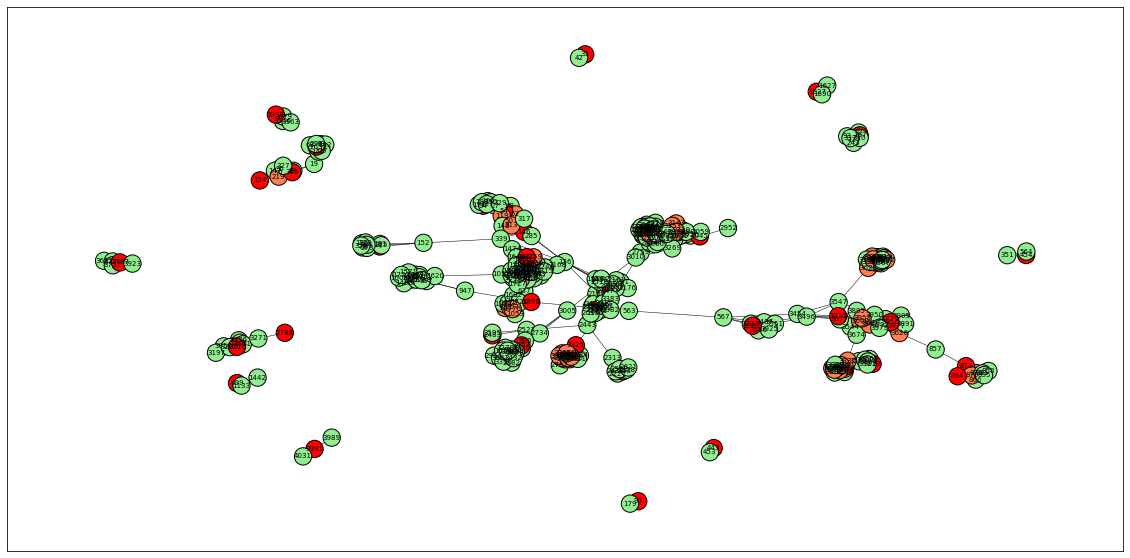

In [18]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(subG_2)

nx.draw_networkx_nodes(subG_2, pos, node_size=300,
                               node_color=colors, 
                               vmin=0, vmax=3, 
                               cmap=plt.cm.rainbow,
                               edgecolors='black')
nx.draw_networkx_edges(subG_2, pos,
                       width=0.5,
                       node_size=300)
nx.draw_networkx_labels(subG_2, pos, font_size=7)
plt.show()

In [11]:
nodes_degrees = pd.DataFrame()
for node in good_nodes_2:
    nodes_degrees = nodes_degrees.append({'node': node, 'degree': gc_degrees[node]}, ignore_index=True)
nodes_degrees.sort_values(by=['node'], ascending=False)

,degree,node
9,2.0,3991.0
43,6.0,3961.0
36,3.0,3939.0
32,6.0,3916.0
20,12.0,3892.0
4,12.0,3847.0
39,6.0,3813.0
31,4.0,3787.0
28,8.0,3775.0
30,12.0,3657.0


gc_steps[0] = [3057, 2263, 167, 3991, 3939]<br>
gc_steps[11] = [1304]<br>
gc_steps[12] = [3847]<br>
gc_steps[14] = [2522]<br>
gc_steps[15] = [1084]<br>
gc_steps[16] = [146]<br>
<br>
gc_steps[19] = [2745]<br>
gc_steps[20] = [154]<br>

In [24]:
print(len(good_nodes_2))
good_nodes_2.extend(neigh_2)
good_nodes_2 = list(set(good_nodes_2))
print(len(good_nodes_2))

298
103


In [25]:
%%time
res_test = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
for node in good_nodes_2:
    gc_steps[0] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_test = res_test.append({'node': node, 'profit': result[2], 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_test.sort_values(by=['profit','affected'], ascending=False).head(10)

CPU times: user 15.1 s, sys: 39.5 ms, total: 15.1 s
Wall time: 15.1 s


,A,affected,degree,node,profit
58,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",863.0,37.0,1304.0,1032000.0
102,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",701.0,16.0,3057.0,1030200.0
42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217.0,6.0,2263.0,1009000.0
34,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",69.0,6.0,167.0,1001600.0
84,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",45.0,2.0,3991.0,1001600.0
73,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30.0,3.0,3939.0,1000550.0
91,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.0,1.0,443.0,1000500.0
94,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21.0,2.0,454.0,1000400.0
45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15.0,1.0,2788.0,1000400.0
37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55.0,8.0,3775.0,1000300.0


In [242]:
print(len(good_nodes_2))
for i in [3057, 3775, 2263, 3991,2788,1304,2522,1084,54,167,2745,154,90]:
    good_nodes_2.remove(i)

print(len(good_nodes_2))

46
33


In [48]:
%%time
res_18 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263]
gc_steps[12] = [1304]
gc_steps[13] = [3775]
gc_steps[15] = [2522]
gc_steps[16] = [1084]
gc_steps[17] = [54, 167]
gc_steps[22] = [2745]


for num, node in enumerate(sorted(good_nodes_2)):
    if node in [3057, 2263, 1304, 3775, 2522, 1084, 54, 167, 2745]:
        continue
    if num % 10 == 0:
        print(num, node)
    #gc_steps[15] = [1084]
    #gc_steps[15].append(node)
    gc_steps[23] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_18 = res_18.append({'node': node, 'profit': result[2] - 1000000, 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
res_18.sort_values(by=['profit', 'affected'], ascending=False).head(10)


0 4
10 219
20 899
30 1236
50 2889
60 3153
70 3423
80 3628
90 3787
100 3953
CPU times: user 9min 49s, sys: 1.12 s, total: 9min 50s
Wall time: 9min 52s


,A,affected,degree,node,profit
7,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3397.0,1.0,154.0,127350.0
21,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,11.0,943.0,127300.0
22,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,6.0,985.0,127300.0
23,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,15.0,1000.0,127300.0
25,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,20.0,1127.0,127300.0
27,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,42.0,1236.0,127300.0
28,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,19.0,1308.0,127300.0
31,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,69.0,1703.0,127300.0
32,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,5.0,1759.0,127300.0
35,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3389.0,9.0,1840.0,127300.0


In [40]:
32 * 300

9600

In [183]:
10000 - gc_degrees[3057] * 300 - gc_degrees[3775] * 300 - gc_degrees[2263] * 300

1000

In [50]:
%%time
res = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 154]#, 3775, 3991]#, 443]
gc_steps[12] = [1304]
gc_steps[13] = [3775]
gc_steps[15] = [2522]
gc_steps[16] = [1084]
gc_steps[17] = [54, 167]
gc_steps[22] = [2745]

#gc_steps[21] = [1084]
#gc_steps[23] = [54, 167, 2788, 154]
#gc_steps[25] = [2745]
#gc_steps[26] = [319]

result = process_campaign(G, gc_steps, logs=2)
res = res.append({'node': gc_steps[0], 'profit': result[2] - 10000, 'affected': result[1],'A': result[0]}, ignore_index=True)

res.sort_values(by=['profit','affected'], ascending=False)

1 Количество зараженных: 7.0, бюджет: 3300
2 Количество зараженных: 11.0, бюджет: 3500
3 Количество зараженных: 17.0, бюджет: 3800
4 Количество зараженных: 28.0, бюджет: 4350
5 Количество зараженных: 34.0, бюджет: 4650
6 Количество зараженных: 36.0, бюджет: 4750
7 Количество зараженных: 44.0, бюджет: 5150
8 Количество зараженных: 53.0, бюджет: 5600
9 Количество зараженных: 64.0, бюджет: 6150
10 Количество зараженных: 86.0, бюджет: 7250
11 Количество зараженных: 122.0, бюджет: 9050
12 Количество зараженных: 182.0, бюджет: 900
13 Количество зараженных: 231.0, бюджет: 900
14 Количество зараженных: 288.0, бюджет: 3750
15 Количество зараженных: 346.0, бюджет: 2700
16 Количество зараженных: 409.0, бюджет: 1600
17 Количество зараженных: 484.0, бюджет: 1350
18 Количество зараженных: 539.0, бюджет: 4100
19 Количество зараженных: 569.0, бюджет: 5600
20 Количество зараженных: 597.0, бюджет: 7000
21 Количество зараженных: 630.0, бюджет: 8650
22 Количество зараженных: 664.0, бюджет: 700
23 Количест

,A,affected,node,profit
0,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3397.0,"[3057, 2263, 154]",127350.0


In [53]:
A_start = list(res.iloc[0]['A'])
neighbors = []
for node in list(G.nodes):
    if A_start[node] == 1.0:
        node_neighbors = list(G.neighbors(node))
        for neighbor in node_neighbors:
            if A_start[neighbor] == 0.0:
                neighbors.append(neighbor)

next_nodes = []
for node in list(G.nodes):
    if A_start[node] == 0.0:
        next_nodes.append(node)


neighbors = list(set(neighbors))
next_nodes = list(set(next_nodes))
print(f'Узлы для 21 дня: {len(next_nodes)}')

Узлы для 21 дня: 556


In [54]:
%%time
res_18 = pd.DataFrame()
steps_keys = list(range(0, 61))
gc_steps = {}
for k in steps_keys:
    gc_steps[k] = []
gc_steps[0] = [3057, 2263, 154]#, 3775, 3991]#, 443]
gc_steps[12] = [1304]
gc_steps[13] = [3775]
gc_steps[15] = [2522]
gc_steps[16] = [1084]
gc_steps[17] = [54, 167]
gc_steps[22] = [2745]


for num, node in enumerate(sorted(next_nodes)):
    #gc_steps[15] = [1084]
    #gc_steps[15].append(node)
    gc_steps[23] = [node]
    result = process_campaign(G, gc_steps, budget=1000000)
    res_18 = res_18.append({'node': node, 'profit': result[2] - 1000000, 'affected': result[1],'A': result[0], 'degree': gc_degrees[node]}, ignore_index=True)
    if num % 10 == 0:
        print(num, node)
        print(max(res_18['profit']))
res_18.sort_values(by=['profit', 'affected'], ascending=False).head(10)


0 4
125050.0
10 233
127150.0
20 578
127150.0
30 632
127150.0
40 662
127150.0
50 693
127150.0
60 704
127150.0
70 714
127150.0
80 724
127150.0
90 734
127150.0
100 744
127150.0
110 754
127150.0
120 764
127150.0
130 774
127150.0
140 784
127150.0
150 794
127150.0
160 805
127150.0
170 815
127150.0
180 825
127150.0
190 835
127150.0
200 845
127150.0
210 855
127150.0
220 870
127150.0
230 881
127150.0
240 894
127150.0
250 1953
127150.0
260 1989
127150.0
270 2040
127150.0
280 2063
127150.0
290 2086
127150.0
300 2109
127150.0
310 2139
127150.0
320 2184
127150.0
330 2218
127150.0
340 2258
127150.0
350 2300
127150.0
360 2329
127150.0
370 2359
127150.0
380 2391
127150.0
390 2418
127150.0
400 2460
127150.0
410 2485
127150.0
420 2521
127150.0
430 2551
127150.0
440 2573
127150.0
450 2593
127150.0
460 2619
127150.0
470 2670
127150.0
480 2879
127150.0
490 3074
127150.0
500 3311
127150.0
510 3479
127150.0
520 3594
127150.0
530 3739
127150.0
540 3874
127150.0
550 4001
127150.0
CPU times: user 58min 51s, sys

,A,affected,degree,node,profit
4,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,90.0,127150.0
5,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,145.0,127150.0
105,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,749.0,127150.0
131,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3400.0,1.0,775.0,127150.0
1,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,33.0,127100.0
2,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,42.0,127100.0
10,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,233.0,127100.0
11,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,244.0,127100.0
12,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,256.0,127100.0
15,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",3399.0,1.0,282.0,127100.0


Дальше нет смысла добавлять.<br>
**Результат:**<br>
gc_steps[0] = [3057, 2263, 154]<br>
gc_steps[12] = [1304]<br>
gc_steps[13] = [3775]<br>
gc_steps[15] = [2522]<br>
gc_steps[16] = [1084]<br>
gc_steps[17] = [54, 167]<br>
gc_steps[22] = [2745]

In [51]:
with open('competititon_2_submission_8.txt', mode='w') as f1:
    result = ''
    result += str(gc_steps)
    f1.write(result)

In [52]:
with open('competititon_2_submission_8.txt', mode='r') as f1:
    s = f1.read()
print(s[:100])

{0: [3057, 2263, 154], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []
